In [1]:
!pip install opencv-python
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
categories = os.listdir("C:/Users/Shireen/A FINAL SER ATTEMPT/data/spectograms/images/")
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            img_array = Image.fromarray(img, 'RGB')
            
            #resize image to 224 x 224 because the input image resolution for Resnet50 is 224 x 224
            resized_img = img_array.resize((224, 224))
            
            img_lst.append(np.array(resized_img))
            
            labels.append(index)
    return img_lst, labels

fpath = "C:/Users/Shireen/A FINAL SER ATTEMPT/data/spectograms/images/"
images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

No. of images loaded =  1440 
No. of labels loaded =  1440
<class 'list'> <class 'list'>


In [3]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (1440, 224, 224, 3) 
Labels shape =  (1440,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [4]:
#1-step in data shuffling
random_seed=42
#get equally spaced numbers in a given range
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

#shuffle all the equally spaced values in list 'n'
np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [   0    1    2 ... 1437 1438 1439]

'n' values after shuffling =  [ 168  605  548 ... 1294  860 1126]


In [5]:
#2-step in data shuffling

#shuffle images and corresponding labels data in both the lists
images = images[n]
labels = labels[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)

Images shape after shuffling =  (1440, 224, 224, 3) 
Labels shape after shuffling =  (1440,)


In [6]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (1440, 224, 224, 3)


In [7]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder

In [8]:
IMG_SHAPE = images.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 32)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 32)                4816928   
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       4967424   
Total params: 9,784,352
Trainable params: 9,784,352
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
history = autoencoder.fit(x=images, y=images, epochs=20,
                validation_data=[images, images])

Epoch 1/20
45/45 [==============================] - 6s 133ms/step - loss: 0.0593 - val_loss: 0.0000e+00
Epoch 2/20
45/45 [==============================] - 6s 139ms/step - loss: 0.0173 - val_loss: 0.0000e+00
Epoch 3/20
45/45 [==============================] - 6s 138ms/step - loss: 0.0169 - val_loss: 0.0000e+00
Epoch 4/20
45/45 [==============================] - 6s 130ms/step - loss: 0.0165 - val_loss: 0.0000e+00
Epoch 5/20
45/45 [==============================] - 6s 129ms/step - loss: 0.0160 - val_loss: 0.0000e+00
Epoch 6/20
45/45 [==============================] - 6s 131ms/step - loss: 0.0155 - val_loss: 0.0000e+00
Epoch 7/20
45/45 [==============================] - 6s 131ms/step - loss: 0.0152 - val_loss: 0.0000e+00
Epoch 8/20
45/45 [==============================] - 6s 132ms/step - loss: 0.0149 - val_loss: 0.0000e+00
Epoch 9/20
45/45 [==============================] - 6s 132ms/step - loss: 0.0146 - val_loss: 0.0000e+00
Epoch 10/20
45/45 [==============================] - 6s 135ms/st

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


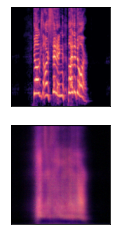

Accuracy= 0.9293321743607521 



In [10]:
decoded_imgs = autoencoder.predict(images)

n = 1
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(images[i].reshape(224, 224,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(224, 224,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("Accuracy=",1-np.mean(abs(images-decoded_imgs)),'\n')

In [11]:
x_train, x_test, y_train, y_test = train_test_split(decoded_imgs, labels, test_size = 0.2, random_state = 42)

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (1152, 224, 224, 3)
y_train shape =  (1152,)

x_test shape =  (288, 224, 224, 3)
y_test shape =  (288,)


In [12]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.layers.normalization import BatchNormalization

In [13]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
from urllib.request import urlopen,urlretrieve
from PIL import Image
from tqdm import tqdm_notebook
%matplotlib inline
from sklearn.utils import shuffle
import cv2
from keras.applications.resnet50 import ResNet50
#from resnets_utils import *

from keras.models import load_model
from sklearn.datasets import load_files   
from keras.utils import np_utils
from glob import glob
from keras import applications
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint

In [28]:
X_train = x_train/255.
X_test = x_test/255.

# Convert training and test labels to one hot matrices
Y_train = np_utils.to_categorical(y_train, 8)
Y_test = np_utils.to_categorical(y_test, 8)

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1152
number of test examples = 288
X_train shape: (1152, 224, 224, 3)
Y_train shape: (1152, 8)
X_test shape: (288, 224, 224, 3)
Y_test shape: (288, 8)


In [15]:
img_height,img_width = 224,224 
num_classes = 8
#If imagenet weights are being loaded, 
#input must have a static square shape (one of (128, 128), (160, 160), (192, 192), or (224, 224))
base_model = applications.resnet50.ResNet50(weights= 'imagenet', include_top=False, input_shape= (img_height,img_width,3))

In [33]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

In [37]:
from keras.optimizers import SGD, Adam
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.00001)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.fit(X_train, Y_train, epochs = 20, batch_size=64)

Epoch 1/20
18/18 [==============================] - 827s 46s/step - loss: 2.4554 - accuracy: 0.2057
Epoch 2/20
18/18 [==============================] - 826s 46s/step - loss: 1.8317 - accuracy: 0.3377
Epoch 3/20
18/18 [==============================] - 843s 47s/step - loss: 1.5628 - accuracy: 0.4444
Epoch 4/20
18/18 [==============================] - 844s 47s/step - loss: 1.2683 - accuracy: 0.5434
Epoch 5/20
18/18 [==============================] - 836s 46s/step - loss: 1.0446 - accuracy: 0.6250
Epoch 6/20
18/18 [==============================] - 827s 46s/step - loss: 0.7891 - accuracy: 0.7240
Epoch 7/20
18/18 [==============================] - 819s 46s/step - loss: 0.5919 - accuracy: 0.8003
Epoch 8/20
18/18 [==============================] - 883s 49s/step - loss: 0.4552 - accuracy: 0.8490
Epoch 9/20
18/18 [==============================] - 921s 51s/step - loss: 0.3178 - accuracy: 0.9062
Epoch 10/20
18/18 [==============================] - 940s 52s/step - loss: 0.2877 - accuracy: 0.9123

In [39]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 8.918905258178711
Test accuracy: 0.1284722238779068


In [38]:
model.fit(X_train, Y_train, epochs = 20, batch_size=64, validation_data=(X_test, Y_test))

Epoch 1/20
18/18 [==============================] - 910s 51s/step - loss: 1.6717 - accuracy: 0.4045 - val_loss: 8.6449 - val_accuracy: 0.1285
Epoch 2/20
18/18 [==============================] - 928s 52s/step - loss: 1.2090 - accuracy: 0.5512 - val_loss: 8.9324 - val_accuracy: 0.1285
Epoch 3/20


KeyboardInterrupt: 